In [2]:
pip install wordcloud

In [3]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

import torch
from torch.utils.data import DataLoader, Dataset, random_split

import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load the CSV files

In [5]:
fake_news = pd.read_csv("Fake.csv")
real_news = pd.read_csv("True.csv")

In [6]:
#labelling the data
fake_news["label"] = 0
real_news["label"] = 1

In [7]:
# extract the columns that we will need for this project
fake_news = fake_news[["text","subject","label"]]
real_news = real_news[["text","subject","label"]]

In [8]:
# joint the two types of news
news = pd.concat([fake_news,real_news])
news = shuffle(news, random_state = 10)

In [9]:
news

,text,subject,label
3040,Democrats stood up for the American people but...,News,0
18131,UNITED NATIONS (Reuters) - Saudi Arabia on Fri...,worldnews,1
6040,Republican House Speaker Paul Ryan has been ge...,News,0
7261,WASHINGTON (Reuters) - U.S. House Democratic L...,politicsNews,1
19492,The Michigan Court of Appeals rejected Green P...,left-news,0
...,...,...,...
16578,TOKYO (Reuters) - Japan s Prime Minister Shinz...,worldnews,1
4536,(Reuters) - Highlights of the day for U.S. Pre...,politicsNews,1
5718,(Reuters) - The Republican-controlled Iowa sta...,politicsNews,1
16580,BEIJING (Reuters) - China s ruling Communist P...,worldnews,1


# Data Cleaning

In [10]:
news.dropna(axis=0)

,text,subject,label
3040,Democrats stood up for the American people but...,News,0
18131,UNITED NATIONS (Reuters) - Saudi Arabia on Fri...,worldnews,1
6040,Republican House Speaker Paul Ryan has been ge...,News,0
7261,WASHINGTON (Reuters) - U.S. House Democratic L...,politicsNews,1
19492,The Michigan Court of Appeals rejected Green P...,left-news,0
...,...,...,...
16578,TOKYO (Reuters) - Japan s Prime Minister Shinz...,worldnews,1
4536,(Reuters) - Highlights of the day for U.S. Pre...,politicsNews,1
5718,(Reuters) - The Republican-controlled Iowa sta...,politicsNews,1
16580,BEIJING (Reuters) - China s ruling Communist P...,worldnews,1


In [18]:
def tokenize(sentence):
    tokens = re.split(r'\W+', sentence)
    return tokens

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in words:
        pos = get_wordnet_pos(word)
        lemmatized_words.append(lemmatizer.lemmatize(word,pos))
    return lemmatized_words

def clean_corpus(df):
    total_number_of_corpus = df.shape[0]
    for current_corpus_index, (index, row) in enumerate(df.iterrows()):
        tokens = tokenize(row['text'])
        lemmatized_words = lemmatize_text(tokens)
        cleaned_text = ' '.join(lemmatized_words)
        # Use iloc to ensure the correct positional index is used
        df.iloc[current_corpus_index, df.columns.get_loc('cleaned_text')] = cleaned_text
        clear_output(wait=True)
        print(df["text"])
        print(df["cleaned_text"])
        print(f"Cleaning process {current_corpus_index + 1}/{total_number_of_corpus}")

In [19]:
clean_corpus(news)

3040     Democrats stood up for the American people but...
18131    UNITED NATIONS (Reuters) - Saudi Arabia on Fri...
6040     Republican House Speaker Paul Ryan has been ge...
7261     WASHINGTON (Reuters) - U.S. House Democratic L...
19492    The Michigan Court of Appeals rejected Green P...
                               ...                        
16578    TOKYO (Reuters) - Japan s Prime Minister Shinz...
4536     (Reuters) - Highlights of the day for U.S. Pre...
5718     (Reuters) - The Republican-controlled Iowa sta...
16580    BEIJING (Reuters) - China s ruling Communist P...
17673    Should legal gun owners be allowed to freely c...
Name: text, Length: 44898, dtype: object
3040     Democrats stood up for the American people but...
18131    UNITED NATIONS Reuters Saudi Arabia on Friday ...
6040     Republican House Speaker Paul Ryan have be get...
7261     WASHINGTON Reuters U S House Democratic Leader...
19492    The Michigan Court of Appeals reject Green Par...
               

In [4]:
#save the cleaned text
# news.to_csv("news_cleaned.csv")
news = pd.read_csv("news_cleaned.csv")

In [5]:
news

,Unnamed: 0,text,subject,label,cleaned_text
0,3040,Democrats stood up for the American people but...,News,0,Democrats stood up for the American people but...
1,18131,UNITED NATIONS (Reuters) - Saudi Arabia on Fri...,worldnews,1,UNITED NATIONS Reuters Saudi Arabia on Friday ...
2,6040,Republican House Speaker Paul Ryan has been ge...,News,0,Republican House Speaker Paul Ryan have be get...
3,7261,WASHINGTON (Reuters) - U.S. House Democratic L...,politicsNews,1,WASHINGTON Reuters U S House Democratic Leader...
4,19492,The Michigan Court of Appeals rejected Green P...,left-news,0,The Michigan Court of Appeals reject Green Par...
...,...,...,...,...,...
44893,16578,TOKYO (Reuters) - Japan s Prime Minister Shinz...,worldnews,1,TOKYO Reuters Japan s Prime Minister Shinzo Ab...
44894,4536,(Reuters) - Highlights of the day for U.S. Pre...,politicsNews,1,Reuters Highlights of the day for U S Preside...
44895,5718,(Reuters) - The Republican-controlled Iowa sta...,politicsNews,1,Reuters The Republican control Iowa state sen...
44896,16580,BEIJING (Reuters) - China s ruling Communist P...,worldnews,1,BEIJING Reuters China s ruling Communist Party...


# Data visualisation

In [23]:
def show_wordcloud(corpus,type_of_data):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=250, colormap='viridis').generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of ' + type_of_data)
    plt.show()

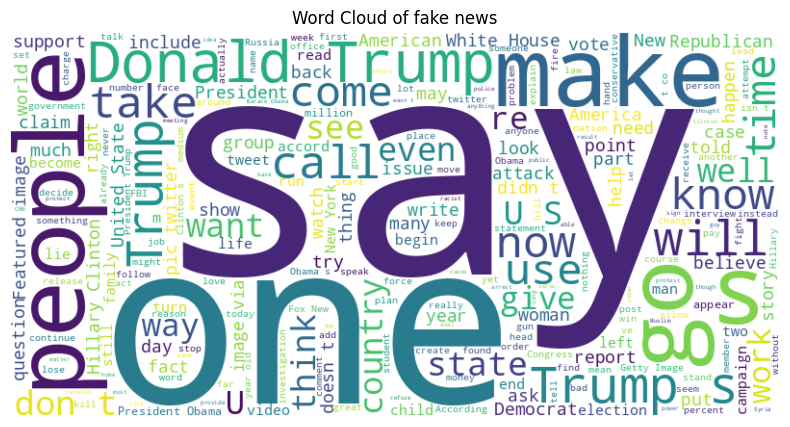

In [24]:
#show wordcloud for fake news
fake_news = news[news["label"] == 0]["cleaned_text"]
fake_news_corpus = ' '.join(fake_news)
show_wordcloud(fake_news_corpus, "fake news")

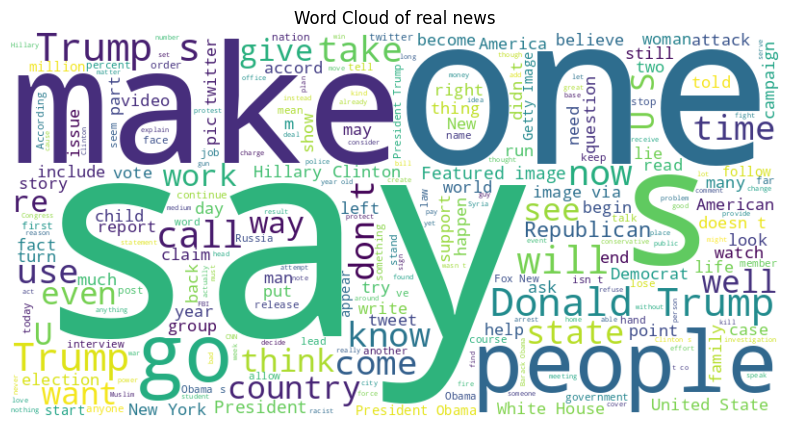

In [25]:
#show wordcloud for fake news
real_news = news[news["label"] == 1]["cleaned_text"]
real_news_corpus = ' '.join(real_news)
show_wordcloud(fake_news_corpus, "real news")

# TF-IDF feature extraction

In [6]:
# embed the corpus with tfidf
tfidfvectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english',max_df=0.8,min_df=5)
tfidf_features = tfidfvectorizer.fit_transform(news['cleaned_text'])

In [7]:
print("fake news feature names: " + tfidfvectorizer.get_feature_names_out()[555:560])

['fake news feature names: 10 governor'
 'fake news feature names: 10 group' 'fake news feature names: 10 gunman'
 'fake news feature names: 10 hour' 'fake news feature names: 10 include']


# Model training

In [8]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_features , news['label'] , test_size = 0.2, random_state = 38)

In [9]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier()
}

results = {
    'Model': [],
    'Dataset': [],
    'F1 Score': [],
    'Accuracy': [],
    'Training Time': []
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions, average='weighted')
    accuracy = accuracy_score(y_test, predictions)

    return f1, accuracy, training_time

In [10]:
# Train and evaluate models on TF-IDF data
for model_name, model in models.items():
    print("training model " + model_name)
    f1, accuracy, training_time = evaluate_model(model, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)
    results['Model'].append(model_name)
    results['Dataset'].append('TF-IDF')
    results['F1 Score'].append(f1)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(training_time)

training model Logistic Regression
training model SVM
training model Random Forest
training model Gradient Boosting


In [11]:
results_df_tfidf = pd.DataFrame(results)
print(results_df_tfidf)

                 Model Dataset  F1 Score  Accuracy  Training Time
0  Logistic Regression  TF-IDF  0.987416  0.987416       9.829782
1                  SVM  TF-IDF  0.995880  0.995880    1614.913458
2        Random Forest  TF-IDF  0.990980  0.990980     131.326436
3    Gradient Boosting  TF-IDF  0.995768  0.995768     420.719461


In [12]:
results_df_tfidf.to_csv("results_tfidf")

# BERT

Now we are going to try with state-of-the-art NLP feature extraction method, BERT
source : https://medium.com/dataness-ai/exploring-bert-feature-extraction-fine-tuning-6d6ad7b829e7

In [13]:
#embed with BERT pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Assuming your data is in a DataFrame called news with a 'cleaned_text' column and a 'label' column
texts = news['cleaned_text'].tolist()
labels = news['label'].tolist()  # Ensure labels are in the correct format (0 for fake, 1 for real)

# Define a custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

dataset = NewsDataset(texts, labels, bert_tokenizer, max_length=64)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # Compute precision, recall, F1-score, and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

In [17]:
trainer = Trainer(
    bert_model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics
)

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.042600,0.012178,0.998334,0.998330,0.998330,0.998330
2,0.000100,0.009740,0.998330,0.998330,0.998330,0.998330
3,0.062300,0.006216,0.999109,0.999109,0.999109,0.999109


TrainOutput(global_step=6735, training_loss=0.015282980574386708, metrics={'train_runtime': 1585.6836, 'train_samples_per_second': 67.954, 'train_steps_per_second': 4.247, 'total_flos': 3543908582407680.0, 'train_loss': 0.015282980574386708, 'epoch': 3.0})

In [19]:
trainer.evaluate()

{'eval_loss': 0.0062156254425644875,
 'eval_precision': 0.9991094959750444,
 'eval_recall': 0.9991091314031181,
 'eval_f1': 0.9991091151139562,
 'eval_accuracy': 0.9991091314031181,
 'eval_runtime': 88.0426,
 'eval_samples_per_second': 101.996,
 'eval_steps_per_second': 6.383,
 'epoch': 3.0}